**Общая информация**

**Срок сдачи:** 16 марта 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_mldata, fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KDTree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold

from scipy.sparse import csr_matrix

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.classes = np.unique(y)
        if self.algorithm == "kd_tree":
            self.tree = KDTree(self.X, leaf_size=self.n_neighbors)
    
    def predict(self, X):
        if self.algorithm == "brute":
            # dist = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
            XX = X.multiply(X) if isinstance(X, csr_matrix) else X ** 2
            YY = self.X.multiply(self.X) if isinstance(self.X, csr_matrix) else self.X ** 2
            dist = XX.sum(axis=1).reshape(-1, 1) - 2 * X @ self.X.T + YY.sum(axis=1).reshape(1, -1)
            dist = dist.sqrt() if isinstance(dist, csr_matrix) else np.sqrt(dist)
            neighbors_idx = np.argpartition(dist, np.arange(self.n_neighbors), axis=1)[:, :self.n_neighbors]
            counts = np.count_nonzero(self.y[neighbors_idx][:, :, None] - self.classes[None, None, :], axis=1)
            classes = self.classes[(self.n_neighbors - counts).argmax(axis=1)]
        else:  # algorithm == "kd_tree"
            _, neighbors_idx = self.tree.query(X, 2)
            
        counts = np.count_nonzero(self.y[neighbors_idx][:, :, None] - self.classes[None, None, :], axis=1)
        classes = self.classes[(self.n_neighbors - counts).argmax(axis=1)]
        return classes

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs(accuracy_score(y_test, my_clf_pred) - accuracy_score(y_test, sklearn_pred)) < 0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

Wall time: 971 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [10]:
%time clf.predict(X_test)

Wall time: 972 µs


array([1, 0, 0, 1, 2, 2, 0, 2, 1, 1, 2, 1, 0, 0, 2])

In [11]:
%time my_clf.predict(X_test)

Wall time: 967 µs


array([1, 0, 0, 1, 2, 2, 0, 2, 1, 1, 2, 1, 0, 0, 2])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

Wall time: 984 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [15]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [16]:
%time clf.predict(X_test)

Wall time: 1 ms


array([2, 1, 0, 0, 1, 0, 1, 0, 2, 0, 1, 2, 1, 2, 2])

In [17]:
%time my_clf.predict(X_test)

Wall time: 0 ns


array([2, 1, 0, 0, 1, 0, 1, 0, 2, 0, 1, 2, 1, 2, 2])

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [19]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [20]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [21]:
X = CountVectorizer(min_df=0.02, max_df=0.9).fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [22]:
folds_num = 3
kfold = KFold(folds_num)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [23]:
def validate(estimator, X, y, kfold):
    val_scores = []
    for train_idx, val_idx in kfold.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], target[val_idx]
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_val)
        val_scores.append(accuracy_score(y_val, y_pred))
    return np.array(val_scores)

In [24]:
neighbors_params = list(range(1, 11))

neighbors_scores = []
for n_neighbors in neighbors_params:
    model = MyKNeighborsClassifier(n_neighbors=n_neighbors)
    neighbors_scores.append(validate(model, X, target, kfold).mean())

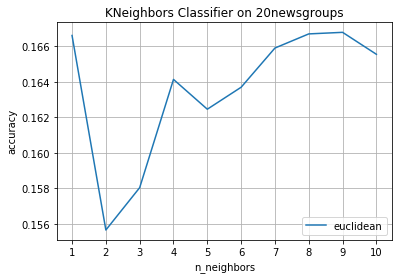

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("KNeighbors Classifier on 20newsgroups")
ax.set_xlabel("n_neighbors")
ax.set_xticks(neighbors_params)
ax.set_ylabel("accuracy")
ax.grid()
ax.plot(neighbors_params, neighbors_scores, label='euclidean')
ax.legend()
plt.show()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [26]:
%%time
res = {}
neighbors_params = list(range(1, 11))
for n_neighbors in neighbors_params:
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    res.setdefault("euclidean_count", []).append(validate(model, X, target, kfold).mean())
for n_neighbors in neighbors_params:
    model = KNeighborsClassifier(n_neighbors=n_neighbors, metric="cosine")
    res.setdefault("cosine_count", []).append(validate(model, X, target, kfold).mean())
                                                 
X = TfidfVectorizer(min_df=0.02, max_df=0.9).fit_transform(data)

for n_neighbors in neighbors_params:
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    res.setdefault("euclidean_tfidf", []).append(validate(model, X, target, kfold).mean())
for n_neighbors in neighbors_params:
    model = KNeighborsClassifier(n_neighbors=n_neighbors, metric="cosine")
    res.setdefault("cosine_tfidf", []).append(validate(model, X, target, kfold).mean())

Wall time: 3min 46s


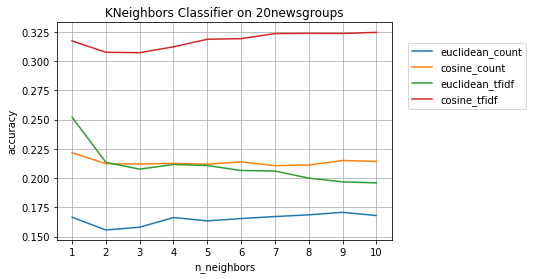

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("KNeighbors Classifier on 20newsgroups")
ax.set_xlabel("n_neighbors")
ax.set_xticks(neighbors_params)
ax.set_ylabel("accuracy")
ax.grid()
for label, scores in res.items():
    ax.plot(neighbors_params, scores, label=label)
ax.legend(loc=(1.05, 0.60))
plt.show()

In [28]:
print("method\t\t\tn_neighbors")
for mehtod, scores in res.items():
    print(f"{mehtod}\t\t{np.array(scores).argmax()}")

method			n_neighbors
euclidean_count		8
cosine_count		0
euclidean_tfidf		0
cosine_tfidf		9


Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [29]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [30]:
data_test = newsgroups['data']
target_test = newsgroups['target']

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [31]:
vectorizer = TfidfVectorizer(min_df=0.02, max_df=0.9).fit(data)
X_train = vectorizer.transform(data)
X_test = vectorizer.transform(data_test)
model.fit(X_train, target)
y_pred = model.predict(X_test)
print(f"accuracy:\t{accuracy_score(target_test, y_pred)}")

accuracy:	0.29460966542750927


Качество отличается, так как мы могли переобучить гиперпараметры на валидационной выборке